In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from astra.torch.models import ResNetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

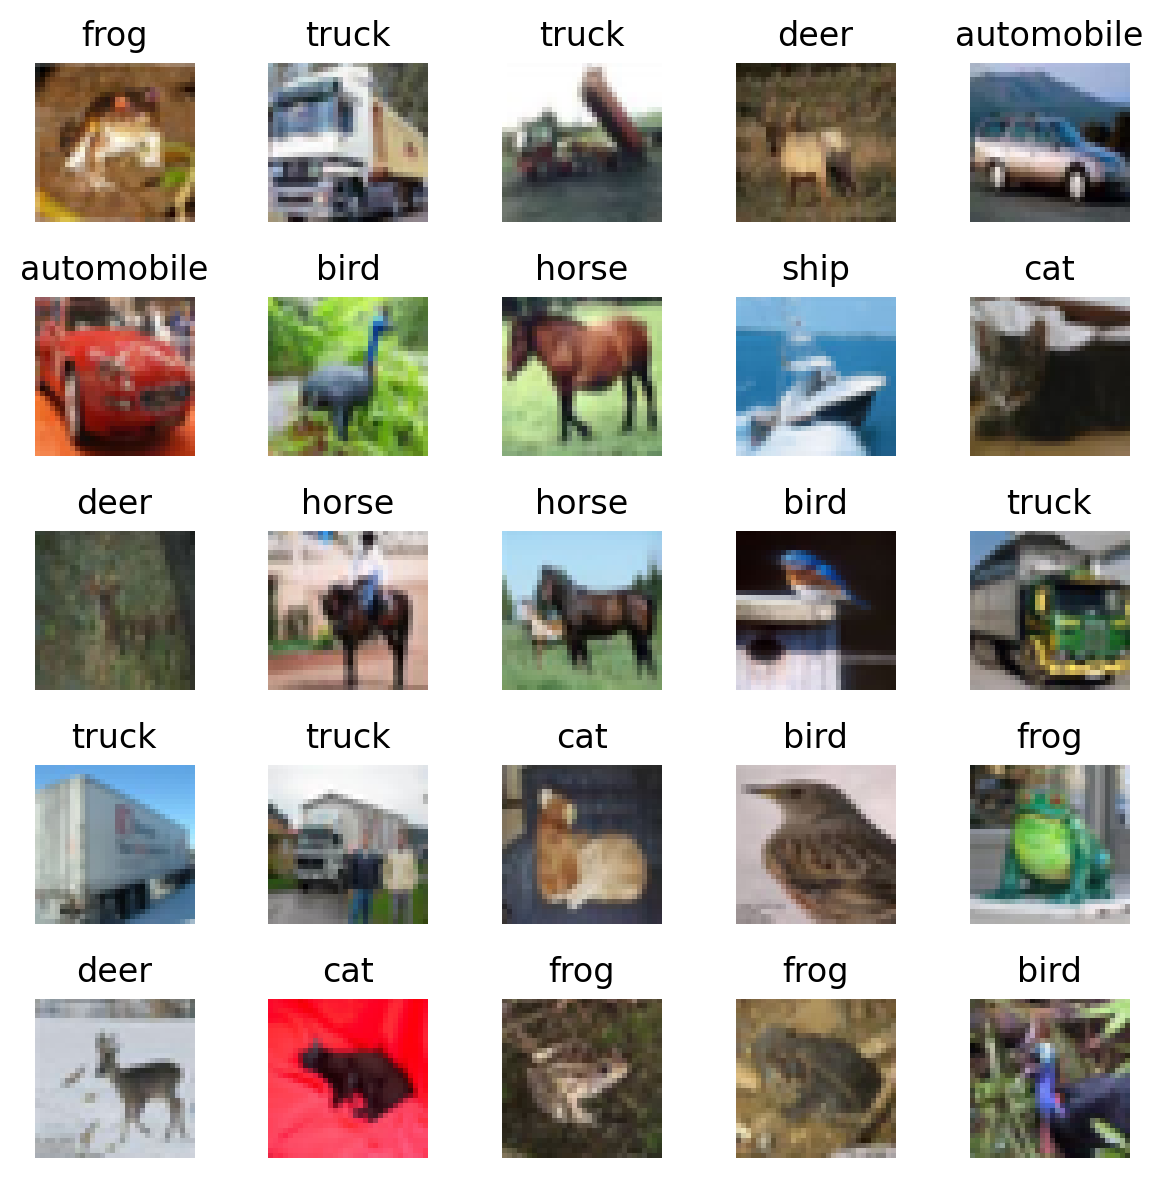

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis("off")
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [6]:
n_train = 1000
n_test = 20000
y = dataset.targets
X = dataset.data
# y = (y==1).int()
# mask=(y==1)
# X=X[mask]
print(y)

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

tensor([6, 9, 9,  ..., 5, 1, 7])
torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
classes = dataset.classes
class_1_idx = classes.index("frog")
print(class_1_idx)

6


In [8]:
class_1_mask = y == class_1_idx
print(class_1_mask)
class_1_mask = class_1_mask.int()
print(class_1_mask)
class_1_mask.shape
y = class_1_mask
# X_class_1 = X[class_1_mask]
# y_class_1 = y[class_1_mask]
# # print(y_class_1)

# X_class_0 = X[~class_1_mask]
# y_class_0 = y[~class_1_mask]
# print(y_class_0)
# print(X_class_0.shape)
# print(X_class_1.shape)
# print(y_class_0.shape)
# print(y_class_1)

# #make a new dataset with only class 1 and class 0
# X=torch.cat((X_class_0,X_class_1),0)
# y=torch.cat((y_class_0,y_class_1),0)
# print(X.shape)
# print(y.shape)

tensor([ True, False, False,  ..., False, False, False])
tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


In [9]:
print(y)

tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


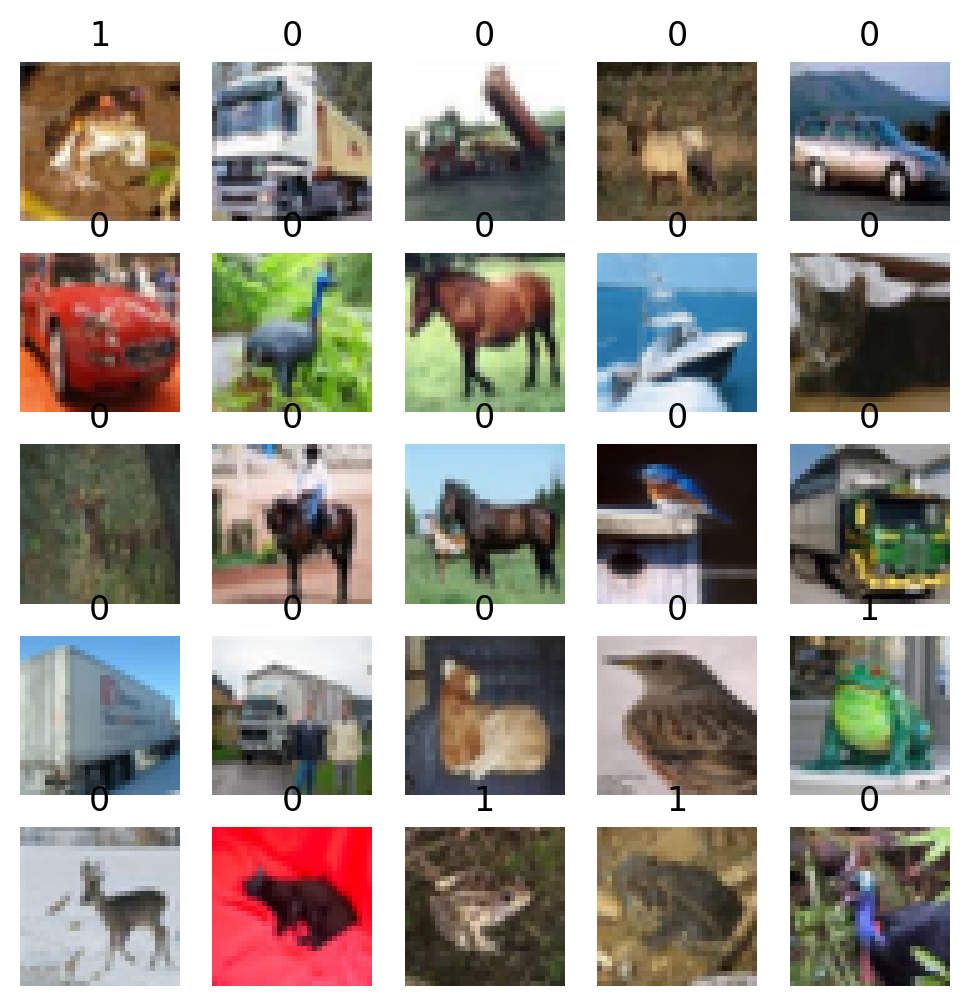

In [10]:
# plot some  images with the new labels in boolean print only label o or 1 not tensor (1,dtype=int64)
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.einsum("chw->hwc", X[i].cpu()))
    plt.axis("off")
    plt.title(y[i].item())

In [11]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [12]:
resnet = ResNetClassifier(
    models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=2
).to(device)
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [13]:
torchsummary.summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

train set accuracy: 13.60%
1000 1000
              precision    recall  f1-score   support

           0       0.94      0.03      0.07       893
           1       0.11      0.98      0.20       107

    accuracy                           0.14      1000
   macro avg       0.52      0.51      0.13      1000
weighted avg       0.85      0.14      0.08      1000



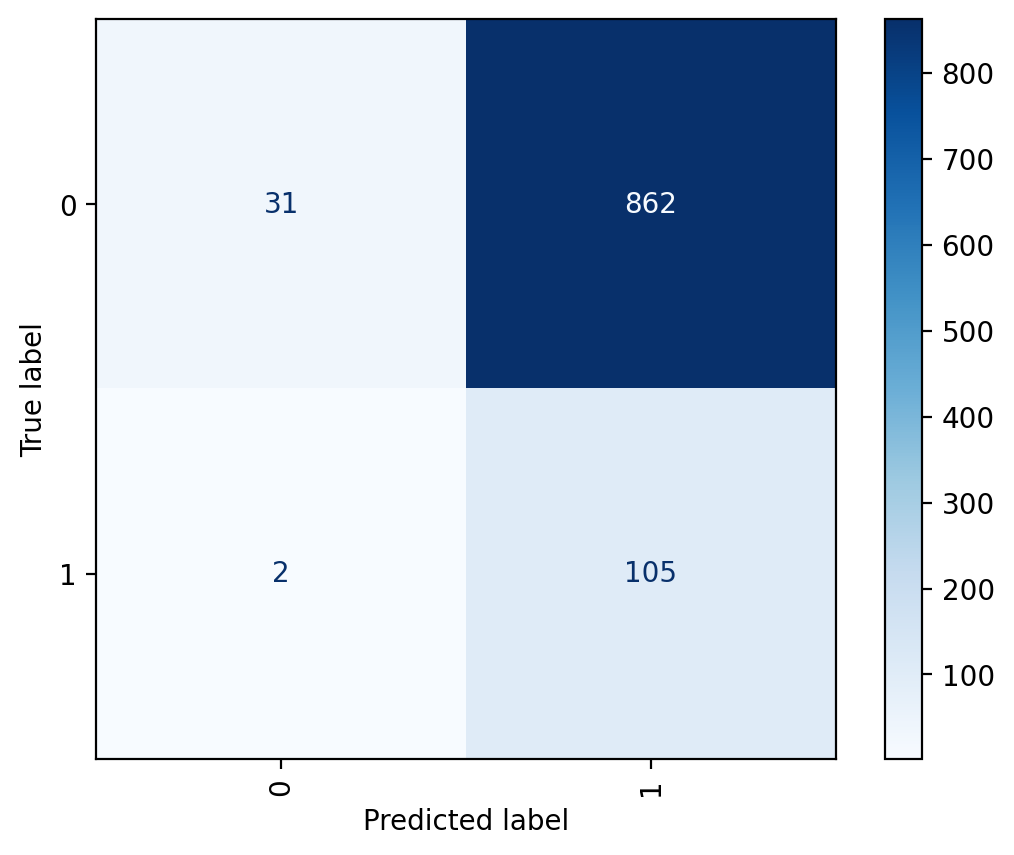

pool set accuracy: 13.01%
39000 39000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     35115
           1       0.10      0.96      0.18      3885

    accuracy                           0.13     39000
   macro avg       0.50      0.50      0.13     39000
weighted avg       0.82      0.13      0.08     39000



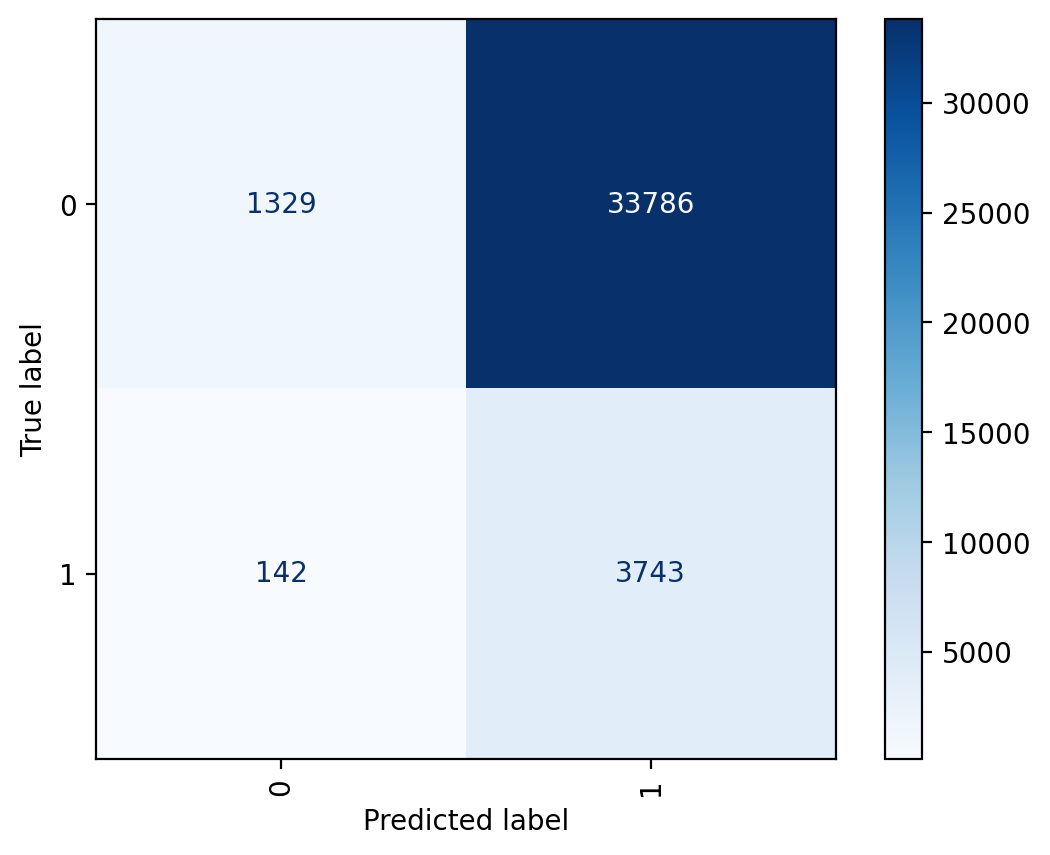

test set accuracy: 13.01%
20000 20000
              precision    recall  f1-score   support

           0       0.90      0.04      0.07     17992
           1       0.10      0.96      0.18      2008

    accuracy                           0.13     20000
   macro avg       0.50      0.50      0.13     20000
weighted avg       0.82      0.13      0.08     20000



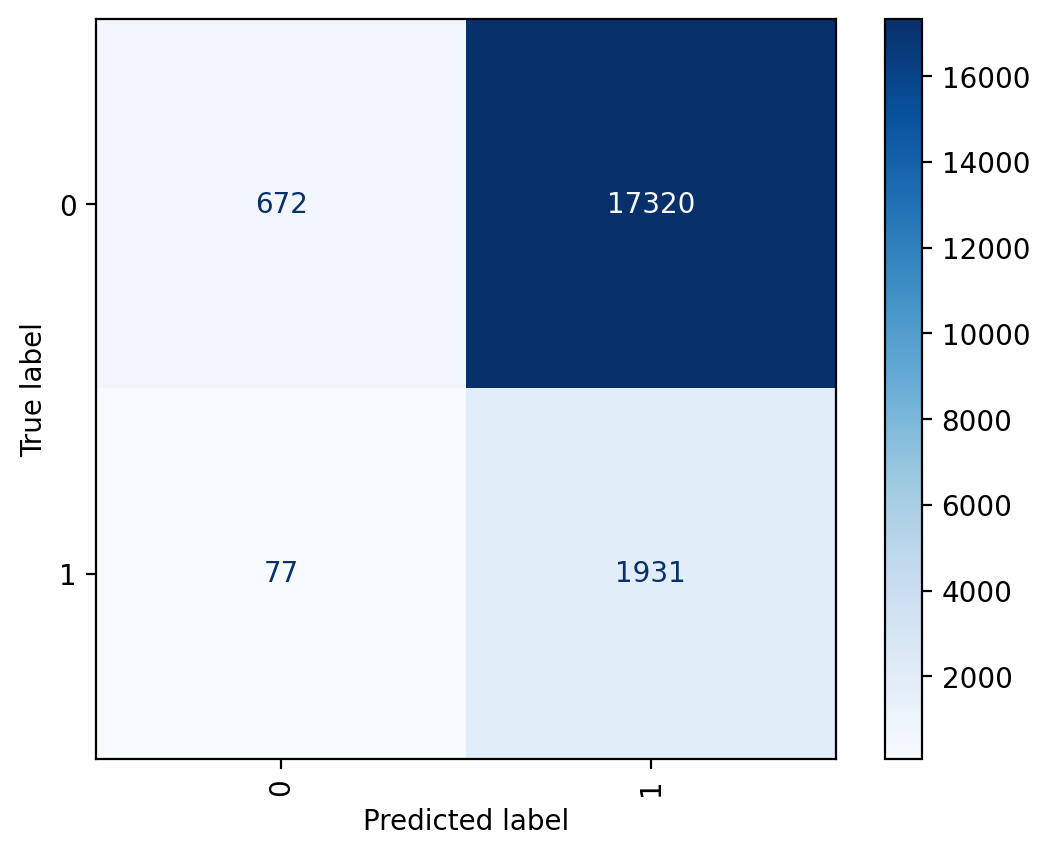

In [14]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc


def predict(net, classes, plot_confusion_matrix=False):
    for i, (name, idx) in enumerate(
        zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])
    ):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        print(f"{name} set accuracy: {acc*100:.2f}%")
        # print the len of true and predicted labels
        print(len(y_dataset), len(y_pred))
        # print classification report
        from sklearn.metrics import classification_report

        print(classification_report(y_dataset.cpu(), y_pred.cpu()))

        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(
                values_format="d", cmap="Blues"
            )
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show()


predict(resnet, ["0", "1"], plot_confusion_matrix=True)

2023-11-06 17:22:30.904809: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 17:22:30.953239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 17:22:31.753841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


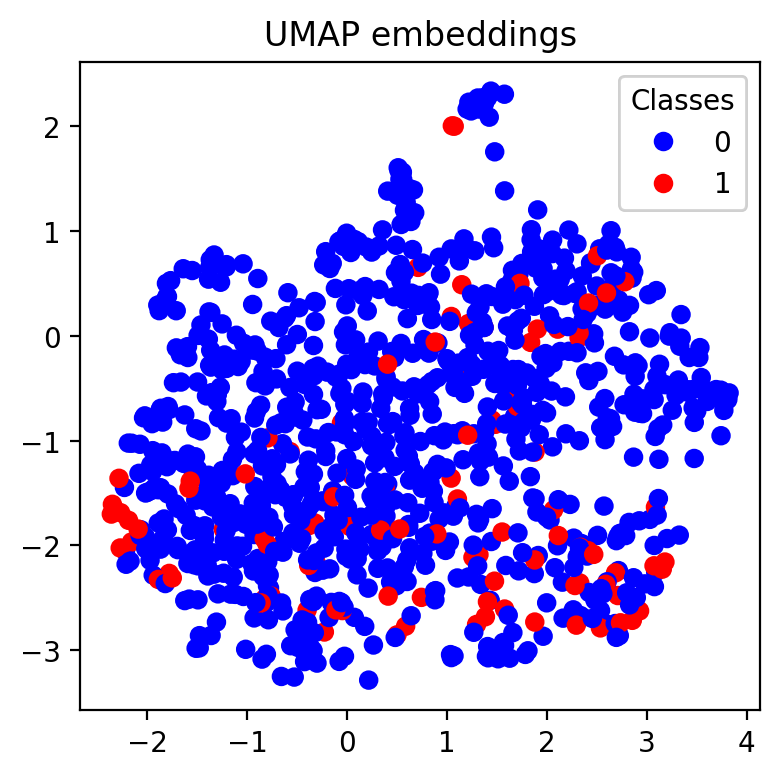

In [15]:
import umap


def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap="bwr")

    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.gca().add_artist(legend1)

    plt.title("UMAP embeddings")
    plt.tight_layout()
    plt.show()


viz_embeddings(resnet, X[train_idx], y[train_idx], device)

In [16]:
print(y[train_idx].shape)
print(X[train_idx].shape)

torch.Size([1000])
torch.Size([1000, 3, 32, 32])


In [17]:
resnet = ResNetClassifier(
    models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1
).to(device)

# Convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=128,
    epochs=30,
    verbose=False,
)

Text(0, 0.5, 'Training loss')

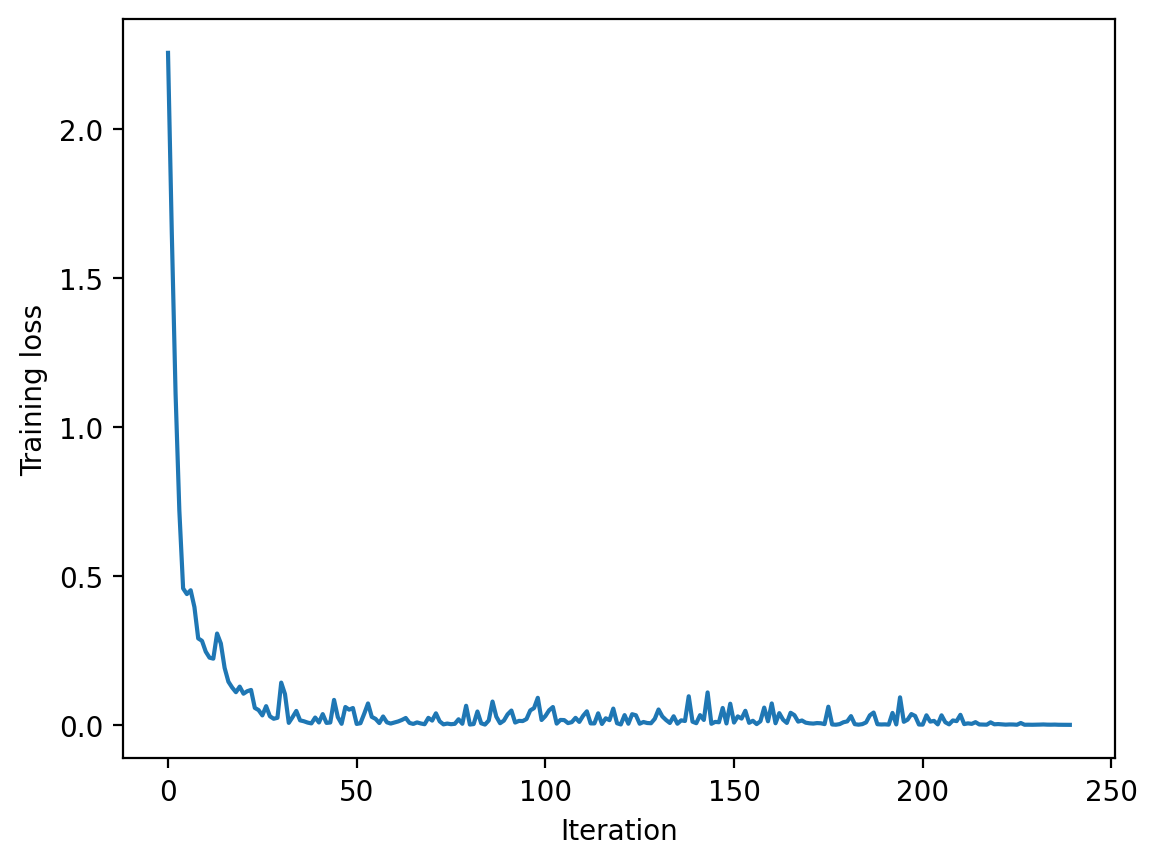

In [18]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



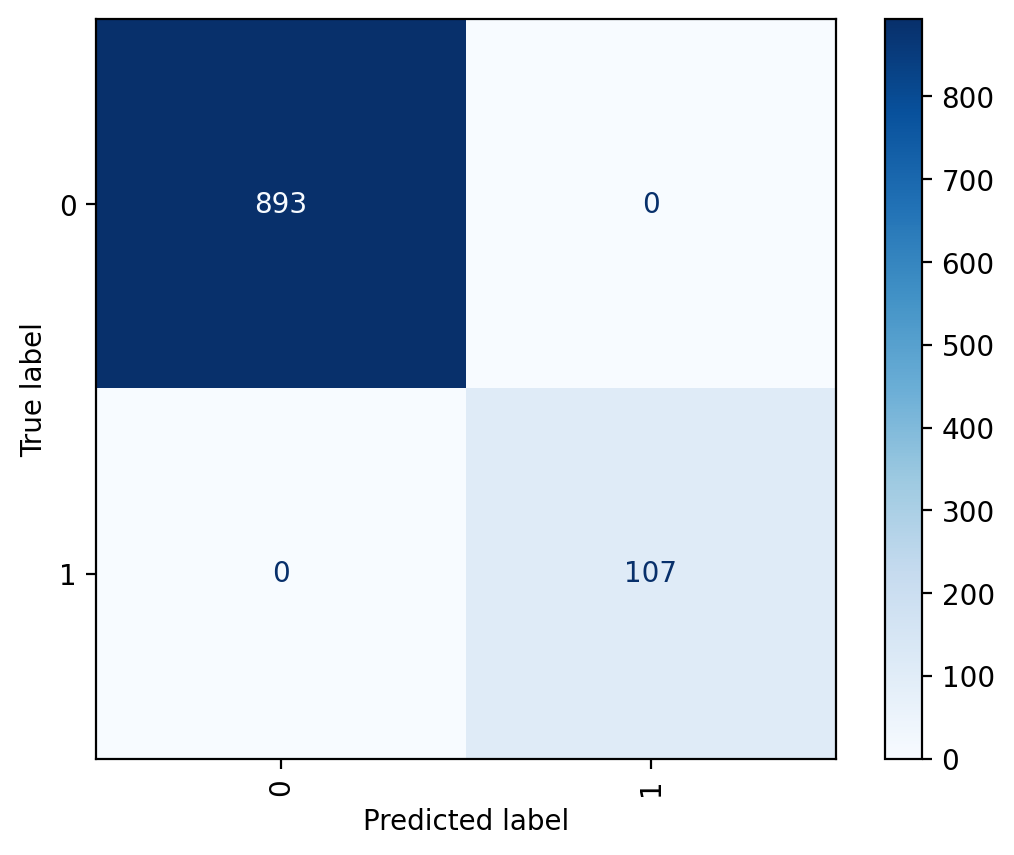

pool set accuracy: 88.80%
39000 39000
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     35115
           1       0.44      0.50      0.47      3885

    accuracy                           0.89     39000
   macro avg       0.69      0.71      0.70     39000
weighted avg       0.89      0.89      0.89     39000



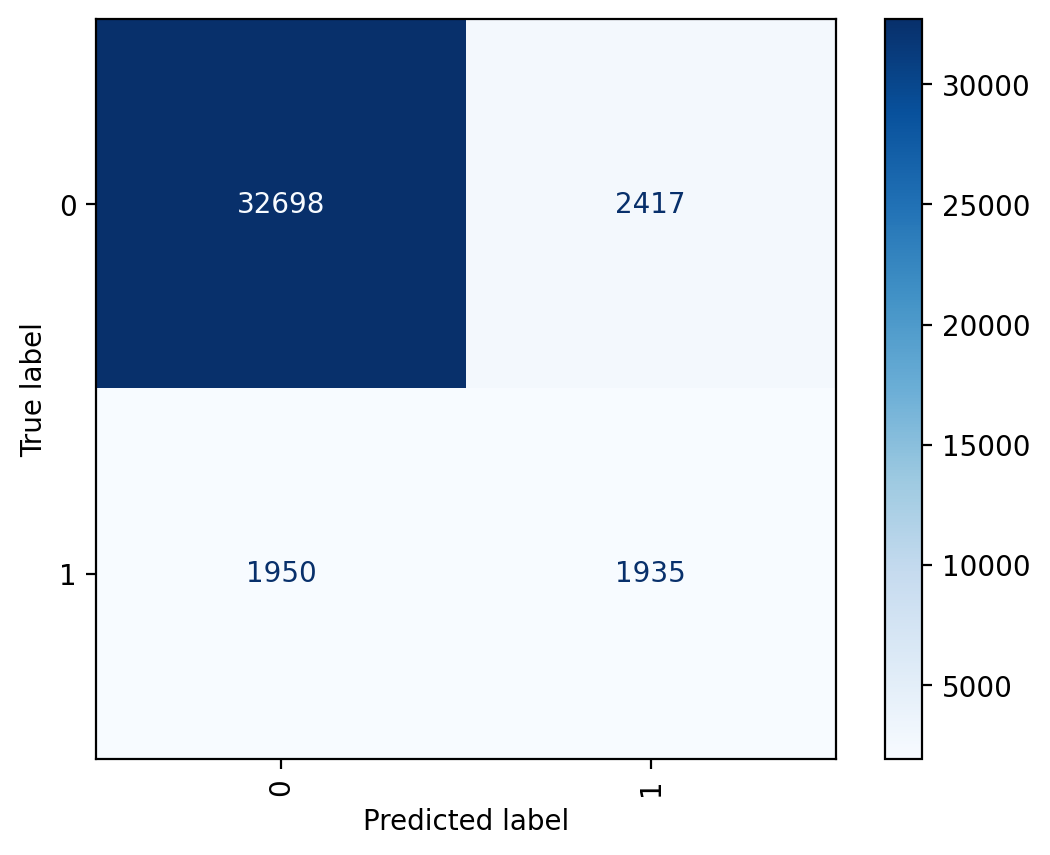

test set accuracy: 88.32%
20000 20000
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     17992
           1       0.43      0.49      0.46      2008

    accuracy                           0.88     20000
   macro avg       0.69      0.71      0.69     20000
weighted avg       0.89      0.88      0.89     20000



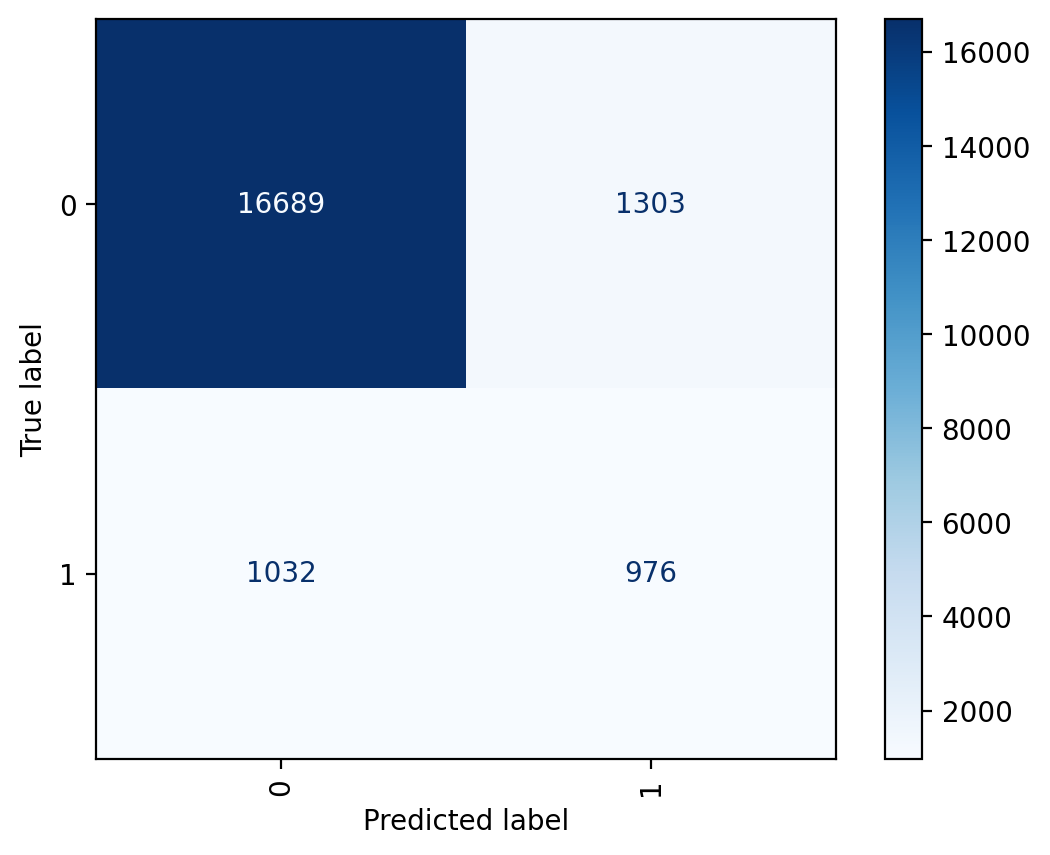

In [19]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

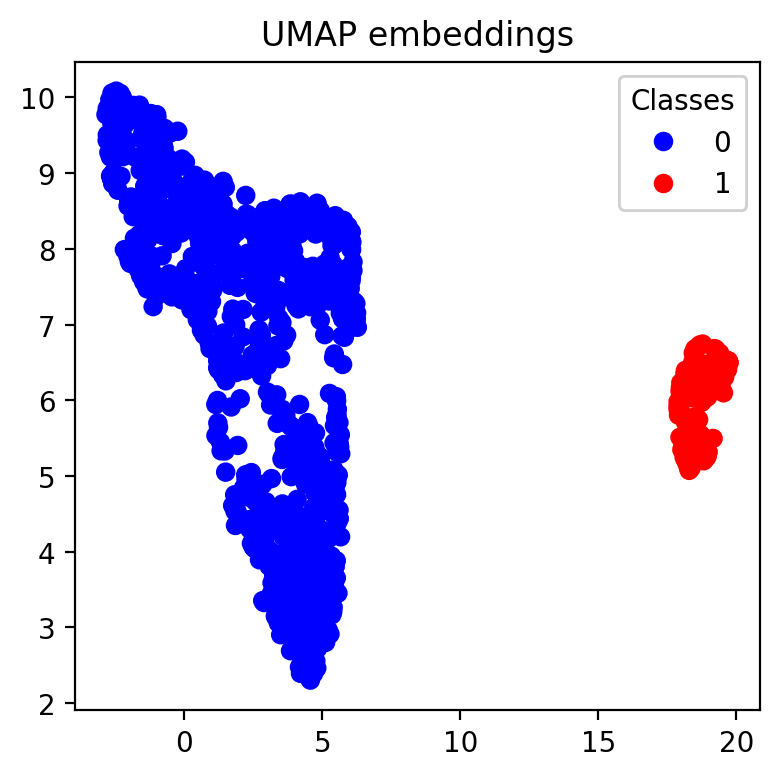

In [20]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

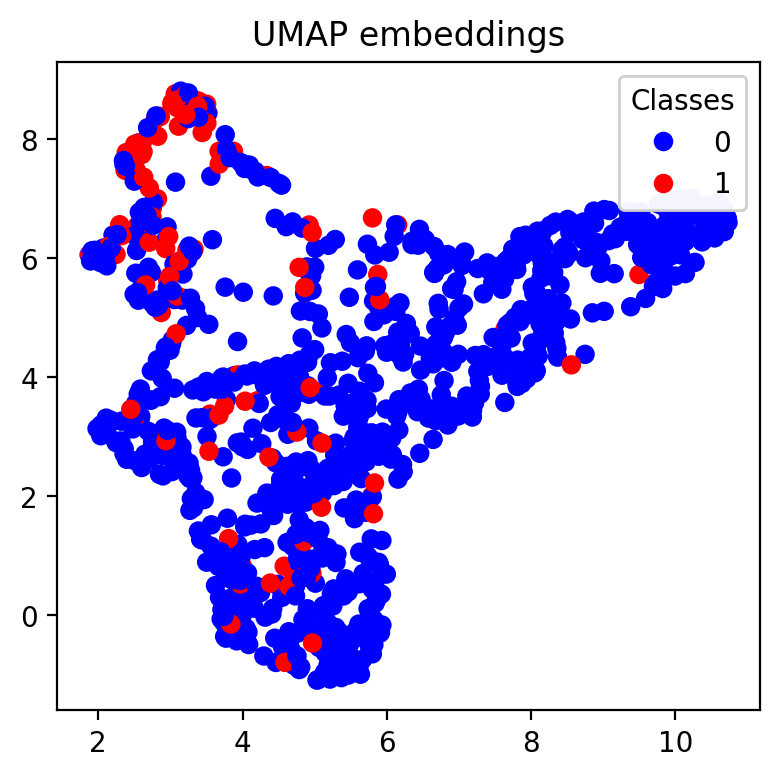

In [21]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [22]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(
    models.resnet18, None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to(device)
# convert X to float and y to long
X_float = X[train_plus_pool_idx].float()
y_long = y[train_plus_pool_idx].long()

iter_losses, epoch_losses = train_fn(
    resnet,
    X_float,
    y_long,
    loss_fn=nn.CrossEntropyLoss(),
    lr=3e-4,
    batch_size=1024,
    epochs=30,
)

Loss: 0.299136: 100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 1: 0.2515143424987793


Loss: 0.122744: 100%|██████████| 40/40 [00:03<00:00, 11.90it/s]


Epoch 2: 0.1595899950027466


Loss: 0.059502: 100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 3: 0.11596029176712036


Loss: 0.103543: 100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 4: 0.08574722137451173


Loss: 0.050808: 100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 5: 0.06971599540710449


Loss: 0.031547: 100%|██████████| 40/40 [00:03<00:00, 11.80it/s]


Epoch 6: 0.057358812141418455


Loss: 0.055755: 100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch 7: 0.04175017657279968


Loss: 0.021612: 100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 8: 0.0546417085647583


Loss: 0.032312: 100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 9: 0.024068390107154846


Loss: 0.011743: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 10: 0.03192511932849884


Loss: 0.004048: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 11: 0.019693299293518065


Loss: 0.003120: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 12: 0.011506913501024247


Loss: 0.007468: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 13: 0.0074176065087318424


Loss: 0.012671: 100%|██████████| 40/40 [00:03<00:00, 11.88it/s]


Epoch 14: 0.015356225949525832


Loss: 0.088110: 100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 15: 0.0238201895236969


Loss: 0.012837: 100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 16: 0.04248949840068817


Loss: 0.016960: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 17: 0.012397081112861634


Loss: 0.005751: 100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 18: 0.017904041540622712


Loss: 0.000433: 100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


Epoch 19: 0.0059833760529756546


Loss: 0.009224: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 20: 0.005263630178570748


Loss: 0.004799: 100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 21: 0.017738752484321593


Loss: 0.000163: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 22: 0.006341788513213396


Loss: 0.000965: 100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 23: 0.0025978521279990674


Loss: 0.000127: 100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 24: 0.0028136330768465997


Loss: 0.000269: 100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 25: 0.0036586660839617252


Loss: 0.061858: 100%|██████████| 40/40 [00:03<00:00, 11.69it/s]


Epoch 26: 0.012213142216205597


Loss: 0.008089: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 27: 0.029766672205924986


Loss: 0.004492: 100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Epoch 28: 0.007912275552749634


Loss: 0.001137: 100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 29: 0.006253002837300301


Loss: 0.101142: 100%|██████████| 40/40 [00:03<00:00, 11.63it/s]

Epoch 30: 0.00533181876912713


Text(0, 0.5, 'Training loss')

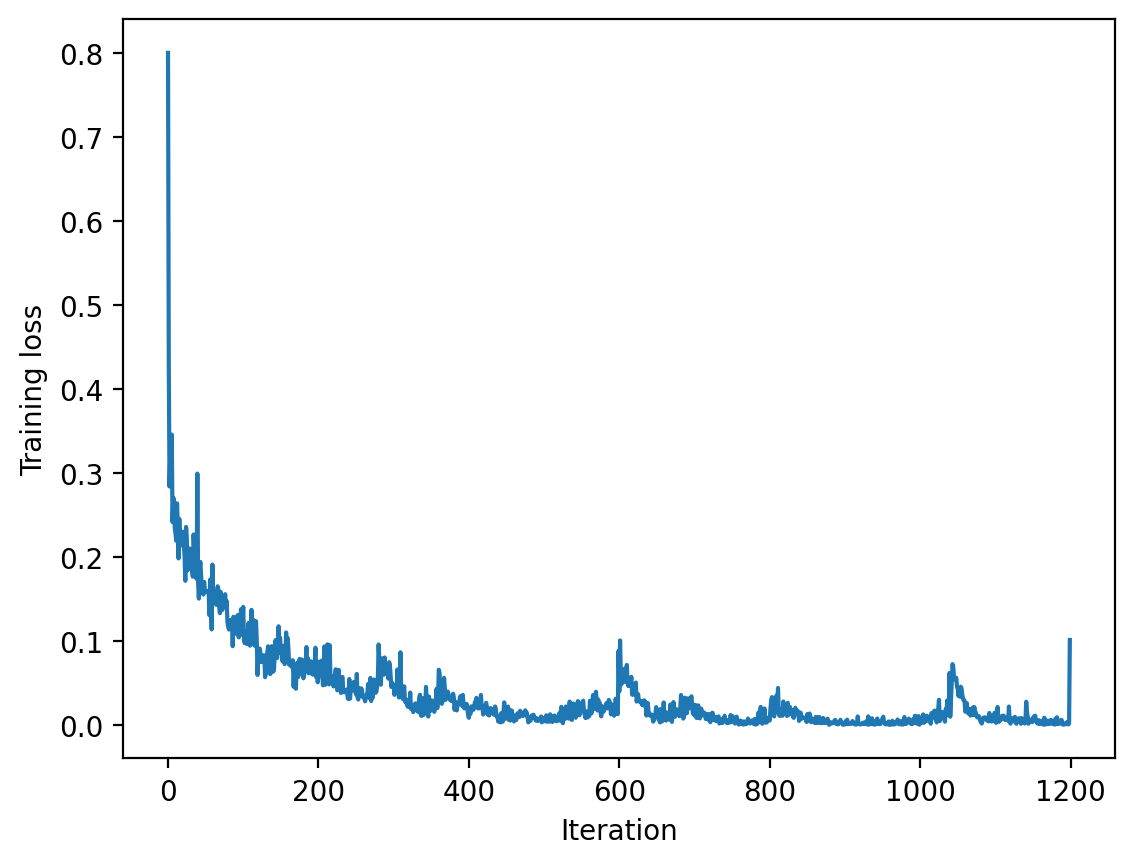

In [23]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

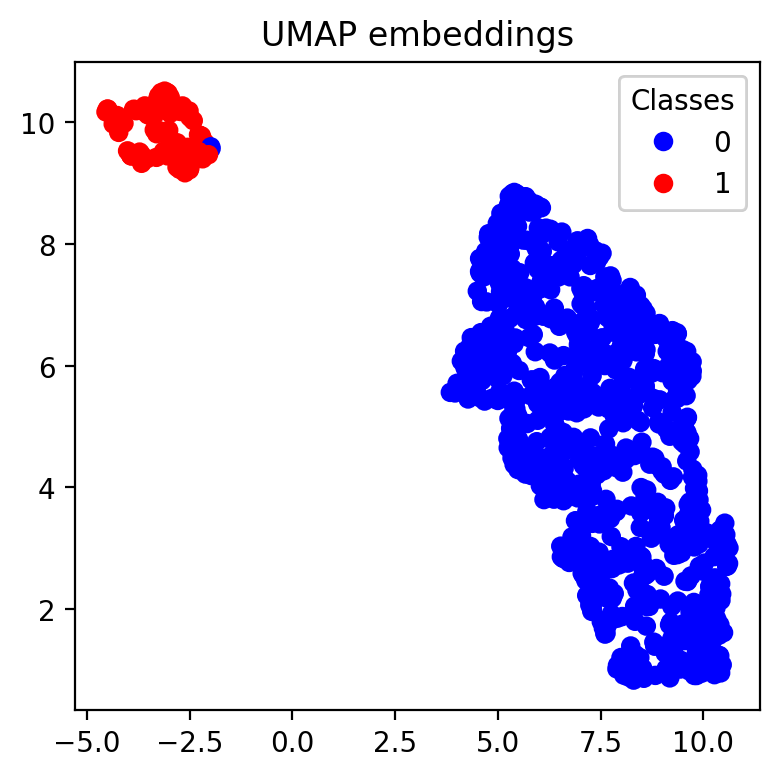

In [24]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

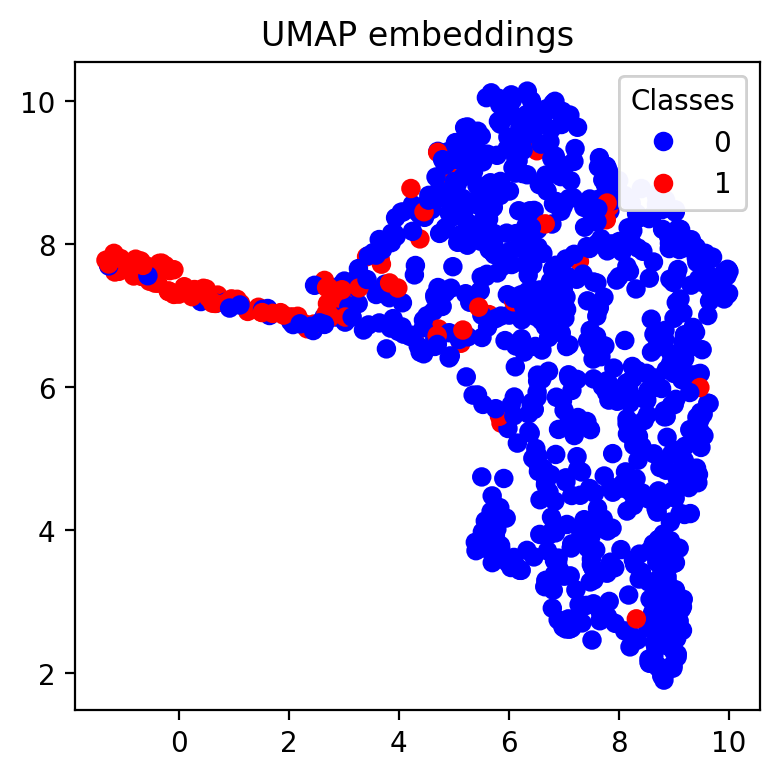

In [25]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.60%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       0.96      1.00      0.98       107

    accuracy                           1.00      1000
   macro avg       0.98      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000



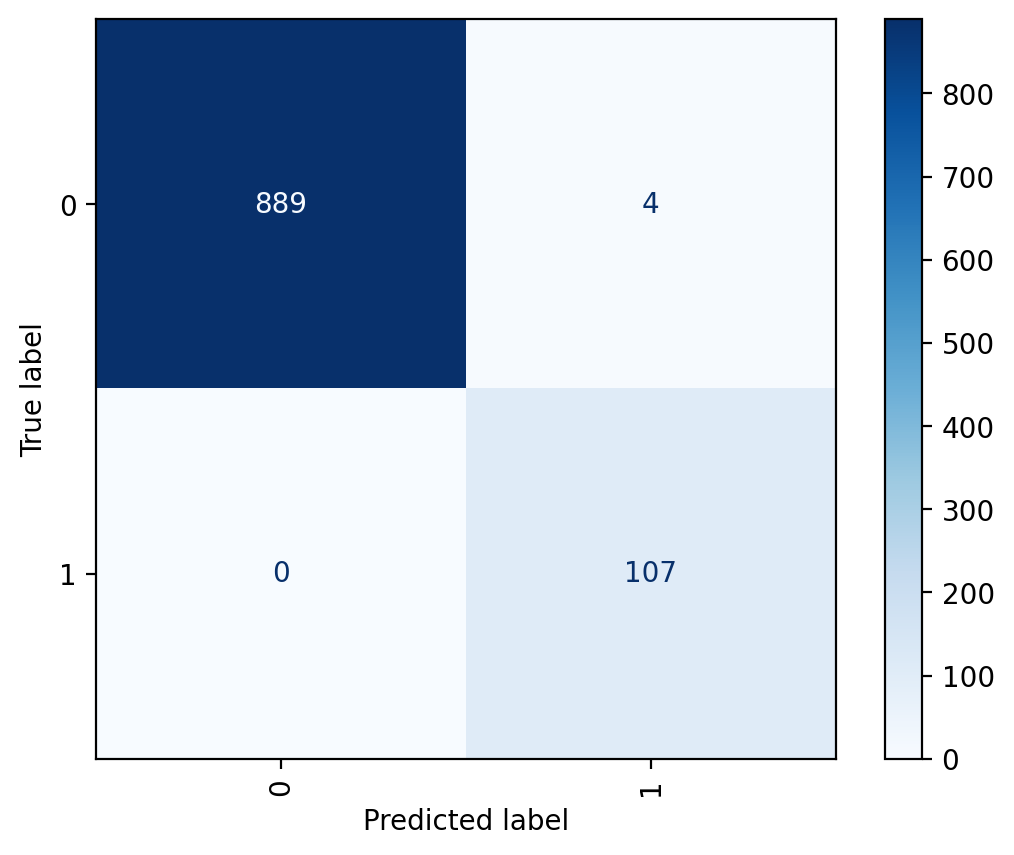

pool set accuracy: 99.35%
39000 39000
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     35115
           1       0.94      1.00      0.97      3885

    accuracy                           0.99     39000
   macro avg       0.97      0.99      0.98     39000
weighted avg       0.99      0.99      0.99     39000



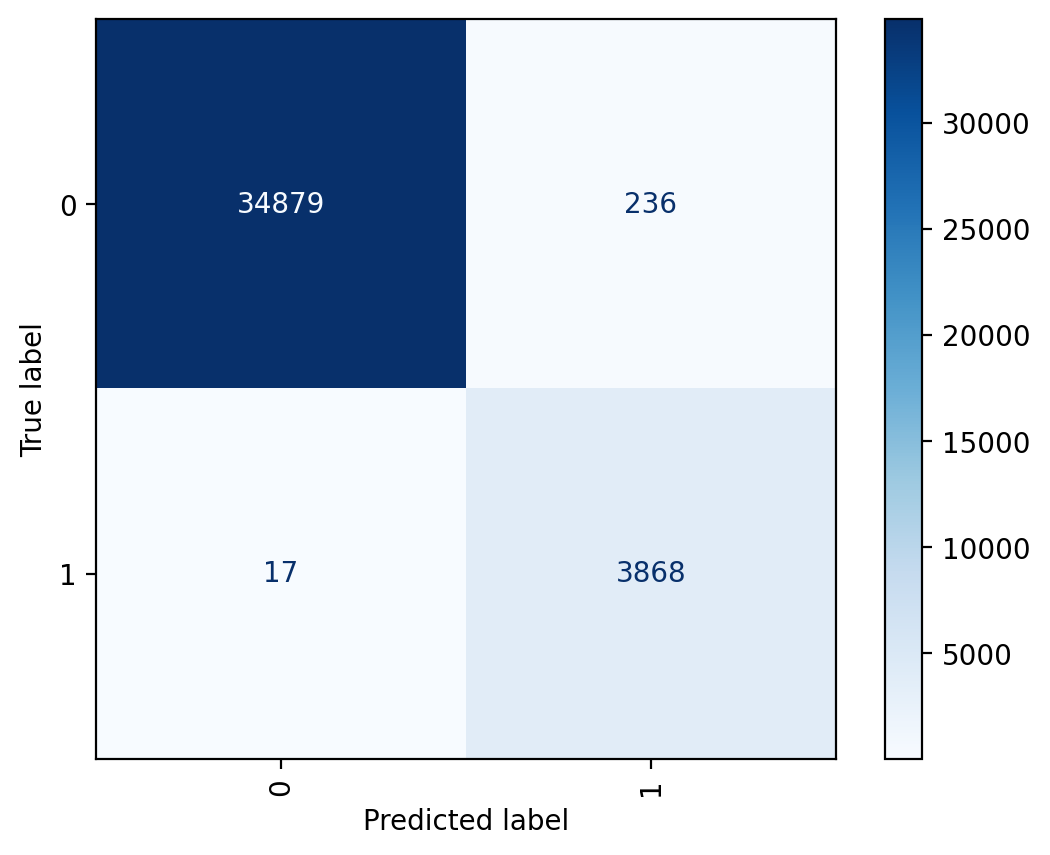

test set accuracy: 93.36%
20000 20000
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     17992
           1       0.65      0.72      0.69      2008

    accuracy                           0.93     20000
   macro avg       0.81      0.84      0.82     20000
weighted avg       0.94      0.93      0.94     20000



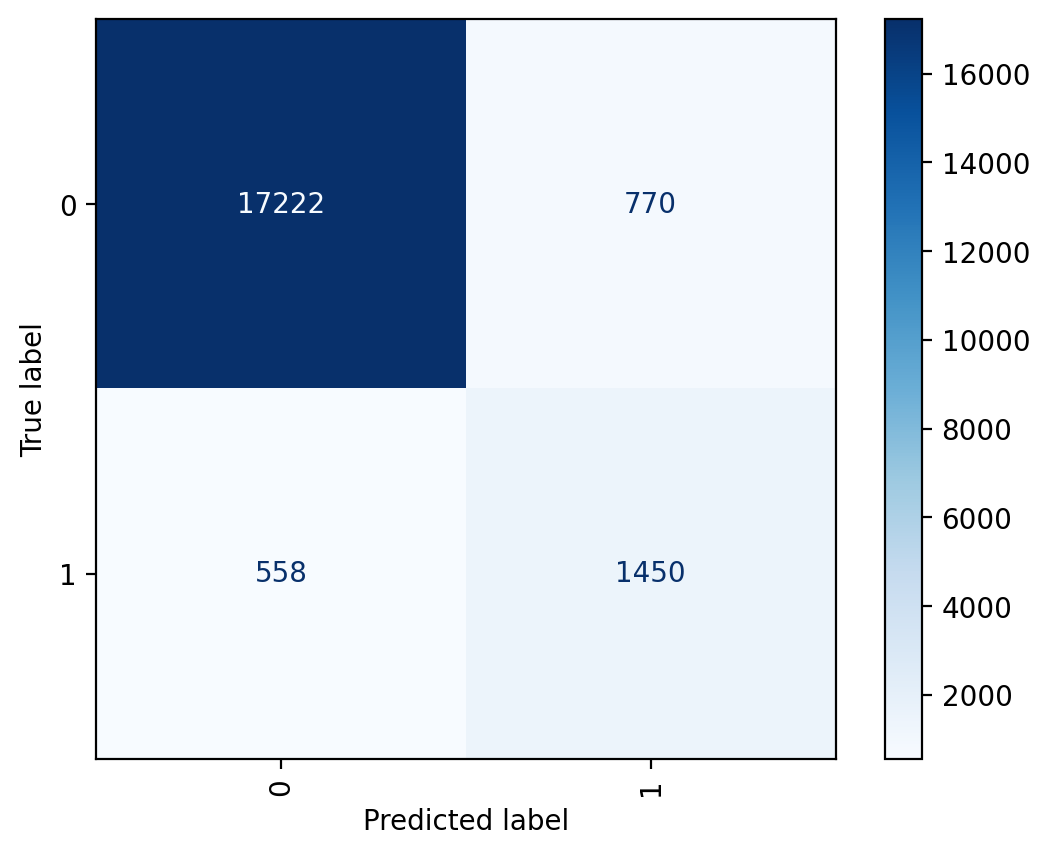

In [26]:
predict(resnet, ["0", "1"], plot_confusion_matrix=True)

## SSL

In [27]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [28]:
X_ssl = []
y_ssl = []

angles_map = {0: 0, 90: 1, 180: 2, 270: 3}
for angle_rot in angles_map.keys():
    print(f"Angle: {angle_rot}")
    X_rot = transforms.functional.rotate(X_train_plus_pool, angle_rot)
    X_ssl.append(X_rot)
    y_ssl.append(torch.tensor([angles_map[angle_rot]] * len(X_rot)))

X_ssl = torch.cat(X_ssl)
y_ssl = torch.cat(y_ssl)

Angle: 0
Angle: 90
Angle: 180
Angle: 270


In [29]:
X_ssl.shape, y_ssl.shape

(torch.Size([160000, 3, 32, 32]), torch.Size([160000]))

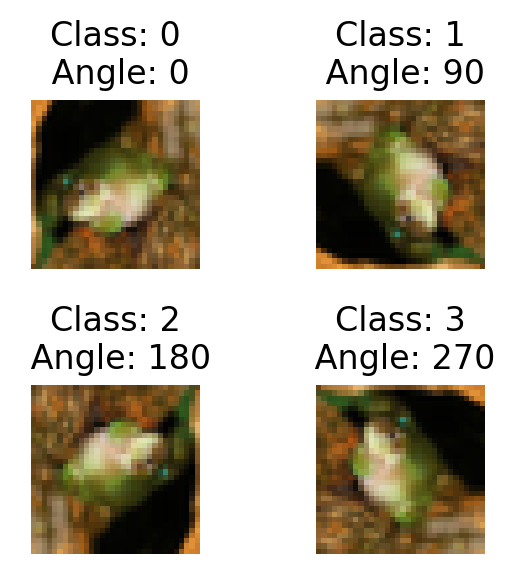

In [30]:
# Plot same image rotated at different angles
def plot_ssl(img_id):
    plt.figure(figsize=(3, 3))
    offset = len(X_train_plus_pool)
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(torch.einsum("chw->hwc", X_ssl[offset * i + img_id]))
        plt.axis("off")
        plt.title(f"Class: {angles_map[i*90]}\n Angle: {i*90}")
    plt.tight_layout()


plot_ssl(6)

In [31]:
ssl_angle = ResNetClassifier(
    models.resnet18, None, n_classes=4, activation=nn.GELU(), dropout=0.1
).to(device)

In [32]:
iter_losses, epoch_losses = train_fn(
    ssl_angle,
    X_ssl,
    y_ssl,
    lr=3e-4,
    loss_fn=nn.CrossEntropyLoss(),
    batch_size=1024,
    epochs=20,
)

Loss: 0.897587: 100%|██████████| 157/157 [00:13<00:00, 11.50it/s]


Epoch 1: 1.0014050678253175


Loss: 0.843980: 100%|██████████| 157/157 [00:13<00:00, 11.52it/s]


Epoch 2: 0.8277547462463379


Loss: 0.741677: 100%|██████████| 157/157 [00:13<00:00, 11.54it/s]


Epoch 3: 0.7282198451995849


Loss: 0.623330: 100%|██████████| 157/157 [00:13<00:00, 11.49it/s]


Epoch 4: 0.6404303203582764


Loss: 0.533001: 100%|██████████| 157/157 [00:13<00:00, 11.48it/s]


Epoch 5: 0.5613861488342285


Loss: 0.513032: 100%|██████████| 157/157 [00:13<00:00, 11.50it/s]


Epoch 6: 0.4777490716934204


Loss: 0.380375: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s]


Epoch 7: 0.40198728523254396


Loss: 0.303032: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


Epoch 8: 0.3298617624282837


Loss: 0.260030: 100%|██████████| 157/157 [00:13<00:00, 11.41it/s]


Epoch 9: 0.2666522590637207


Loss: 0.204917: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


Epoch 10: 0.21446208992004395


Loss: 0.185948: 100%|██████████| 157/157 [00:13<00:00, 11.51it/s]


Epoch 11: 0.17511613149642943


Loss: 0.155521: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s]


Epoch 12: 0.14952844190597533


Loss: 0.160550: 100%|██████████| 157/157 [00:13<00:00, 11.35it/s]


Epoch 13: 0.12467411804199219


Loss: 0.124060: 100%|██████████| 157/157 [00:13<00:00, 11.37it/s]


Epoch 14: 0.10569812257289886


Loss: 0.143271: 100%|██████████| 157/157 [00:13<00:00, 11.40it/s]


Epoch 15: 0.09196240155696869


Loss: 0.118741: 100%|██████████| 157/157 [00:13<00:00, 11.38it/s]


Epoch 16: 0.08176486999988555


Loss: 0.068903: 100%|██████████| 157/157 [00:13<00:00, 11.41it/s]


Epoch 17: 0.07718337943553924


Loss: 0.117798: 100%|██████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 18: 0.06694558854103089


Loss: 0.151988: 100%|██████████| 157/157 [00:13<00:00, 11.44it/s]


Epoch 19: 0.06782926788330078


Loss: 0.091576: 100%|██████████| 157/157 [00:13<00:00, 11.57it/s]


Epoch 20: 0.06443466377258301


Text(0, 0.5, 'Training loss')

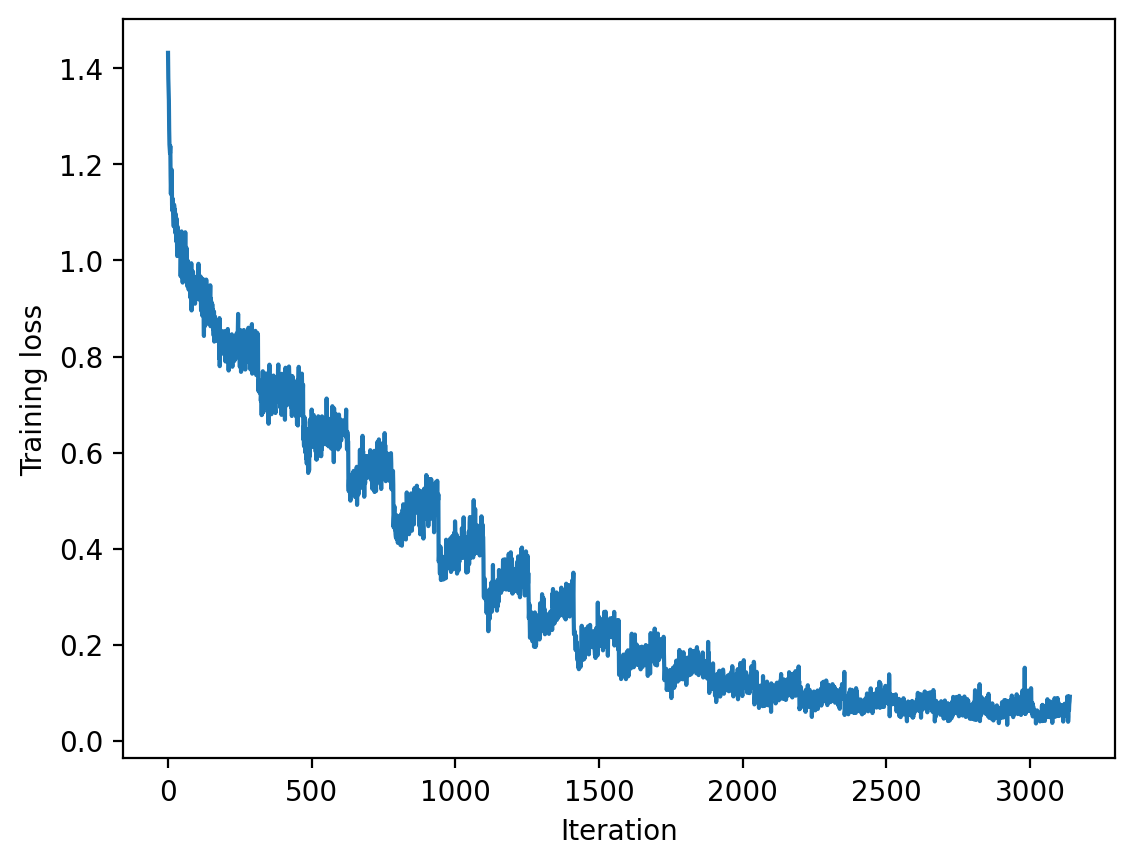

In [33]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

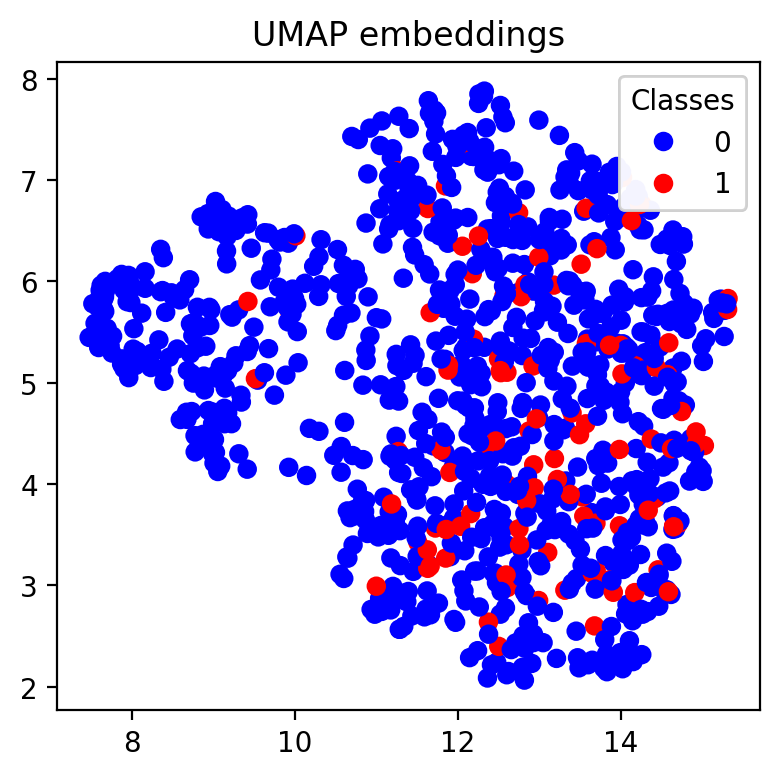

In [34]:
# Visualise the embeddings of the SSL model trained on angles dataset
# (but wrt original 10 classes)
viz_embeddings(ssl_angle, X[train_idx], y[train_idx], device)

In [35]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = ResNetClassifier(
    models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1
).to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())
# convert X to float and y to long
X_float = X[train_idx].float()
y_long = y[train_idx].long()

iter_losses, epoch_losses = train_fn(
    net_pretrained,
    X_float,
    y_long,
    nn.CrossEntropyLoss(),
    lr=3e-4,
    epochs=50,
    batch_size=128,
)

Loss: 0.315108: 100%|██████████| 8/8 [00:00<00:00, 50.64it/s]


Epoch 1: 0.9574505424499512


Loss: 0.144235: 100%|██████████| 8/8 [00:00<00:00, 49.72it/s]


Epoch 2: 0.2210944938659668


Loss: 0.120986: 100%|██████████| 8/8 [00:00<00:00, 50.28it/s]


Epoch 3: 0.08984324550628663


Loss: 0.010349: 100%|██████████| 8/8 [00:00<00:00, 49.92it/s]


Epoch 4: 0.01641253912448883


Loss: 0.002117: 100%|██████████| 8/8 [00:00<00:00, 49.51it/s]


Epoch 5: 0.004500688046216964


Loss: 0.000880: 100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch 6: 0.0016537005603313446


Loss: 0.000382: 100%|██████████| 8/8 [00:00<00:00, 49.84it/s]


Epoch 7: 0.0007513785175979138


Loss: 0.000342: 100%|██████████| 8/8 [00:00<00:00, 49.82it/s]


Epoch 8: 0.00040921981260180475


Loss: 0.000312: 100%|██████████| 8/8 [00:00<00:00, 50.65it/s]


Epoch 9: 0.0003220568932592869


Loss: 0.000384: 100%|██████████| 8/8 [00:00<00:00, 50.73it/s]


Epoch 10: 0.00031123686209321024


Loss: 0.000181: 100%|██████████| 8/8 [00:00<00:00, 49.60it/s]


Epoch 11: 0.00025803612545132636


Loss: 0.000223: 100%|██████████| 8/8 [00:00<00:00, 49.89it/s]


Epoch 12: 0.00019789212383329867


Loss: 0.000169: 100%|██████████| 8/8 [00:00<00:00, 49.03it/s]


Epoch 13: 0.00017067699134349823


Loss: 0.000119: 100%|██████████| 8/8 [00:00<00:00, 49.39it/s]


Epoch 14: 0.00018146673031151295


Loss: 0.000194: 100%|██████████| 8/8 [00:00<00:00, 50.45it/s]


Epoch 15: 0.0001398530313745141


Loss: 0.000119: 100%|██████████| 8/8 [00:00<00:00, 49.29it/s]


Epoch 16: 0.00012739955447614194


Loss: 0.000131: 100%|██████████| 8/8 [00:00<00:00, 50.79it/s]


Epoch 17: 0.00012472671642899512


Loss: 0.000092: 100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch 18: 0.00013047664891928433


Loss: 0.000096: 100%|██████████| 8/8 [00:00<00:00, 49.44it/s]


Epoch 19: 0.00011185559537261725


Loss: 0.000101: 100%|██████████| 8/8 [00:00<00:00, 50.90it/s]


Epoch 20: 9.508489444851875e-05


Loss: 0.000105: 100%|██████████| 8/8 [00:00<00:00, 50.25it/s]


Epoch 21: 0.00010114330798387528


Loss: 0.000110: 100%|██████████| 8/8 [00:00<00:00, 50.03it/s]


Epoch 22: 8.723082859069109e-05


Loss: 0.000148: 100%|██████████| 8/8 [00:00<00:00, 47.93it/s]


Epoch 23: 0.00010989285167306662


Loss: 0.000063: 100%|██████████| 8/8 [00:00<00:00, 49.69it/s]


Epoch 24: 7.477606832981109e-05


Loss: 0.000184: 100%|██████████| 8/8 [00:00<00:00, 49.77it/s]


Epoch 25: 9.651671908795834e-05


Loss: 0.000074: 100%|██████████| 8/8 [00:00<00:00, 49.01it/s]


Epoch 26: 6.904338719323278e-05


Loss: 0.000067: 100%|██████████| 8/8 [00:00<00:00, 51.26it/s]


Epoch 27: 8.469114592298865e-05


Loss: 0.000072: 100%|██████████| 8/8 [00:00<00:00, 49.58it/s]


Epoch 28: 6.493677524849772e-05


Loss: 0.000052: 100%|██████████| 8/8 [00:00<00:00, 49.31it/s]


Epoch 29: 7.167407078668475e-05


Loss: 0.000048: 100%|██████████| 8/8 [00:00<00:00, 50.53it/s]


Epoch 30: 5.659146793186664e-05


Loss: 0.000085: 100%|██████████| 8/8 [00:00<00:00, 49.08it/s]


Epoch 31: 6.631019385531545e-05


Loss: 0.000056: 100%|██████████| 8/8 [00:00<00:00, 49.85it/s]


Epoch 32: 6.025781063362956e-05


Loss: 0.000040: 100%|██████████| 8/8 [00:00<00:00, 49.33it/s]


Epoch 33: 5.005903728306294e-05


Loss: 0.000045: 100%|██████████| 8/8 [00:00<00:00, 51.08it/s]


Epoch 34: 5.119859660044313e-05


Loss: 0.000058: 100%|██████████| 8/8 [00:00<00:00, 50.93it/s]


Epoch 35: 5.2347424905747176e-05


Loss: 0.000244: 100%|██████████| 8/8 [00:00<00:00, 50.26it/s]


Epoch 36: 7.616831781342626e-05


Loss: 0.000038: 100%|██████████| 8/8 [00:00<00:00, 49.95it/s]


Epoch 37: 4.354322841390967e-05


Loss: 0.000048: 100%|██████████| 8/8 [00:00<00:00, 50.21it/s]


Epoch 38: 4.449072666466236e-05


Loss: 0.000035: 100%|██████████| 8/8 [00:00<00:00, 50.54it/s]


Epoch 39: 4.3272940907627346e-05


Loss: 0.000033: 100%|██████████| 8/8 [00:00<00:00, 49.90it/s]


Epoch 40: 3.934049466624856e-05


Loss: 0.000032: 100%|██████████| 8/8 [00:00<00:00, 49.42it/s]


Epoch 41: 4.327656421810389e-05


Loss: 0.000040: 100%|██████████| 8/8 [00:00<00:00, 50.74it/s]


Epoch 42: 4.013067041523754e-05


Loss: 0.000036: 100%|██████████| 8/8 [00:00<00:00, 50.51it/s]


Epoch 43: 3.9328797720372675e-05


Loss: 0.000072: 100%|██████████| 8/8 [00:00<00:00, 45.71it/s]


Epoch 44: 4.2710083071142436e-05


Loss: 0.000040: 100%|██████████| 8/8 [00:00<00:00, 50.28it/s]


Epoch 45: 6.938961171545089e-05


Loss: 0.000026: 100%|██████████| 8/8 [00:00<00:00, 49.16it/s]


Epoch 46: 3.3799117896705866e-05


Loss: 0.000035: 100%|██████████| 8/8 [00:00<00:00, 49.78it/s]


Epoch 47: 3.6553676472976804e-05


Loss: 0.000037: 100%|██████████| 8/8 [00:00<00:00, 49.81it/s]


Epoch 48: 4.105034610256553e-05


Loss: 0.000050: 100%|██████████| 8/8 [00:00<00:00, 49.46it/s]


Epoch 49: 4.453282686881721e-05


Loss: 0.000022: 100%|██████████| 8/8 [00:00<00:00, 50.08it/s]

Epoch 50: 3.358085174113512e-05


Text(0, 0.5, 'Training loss')

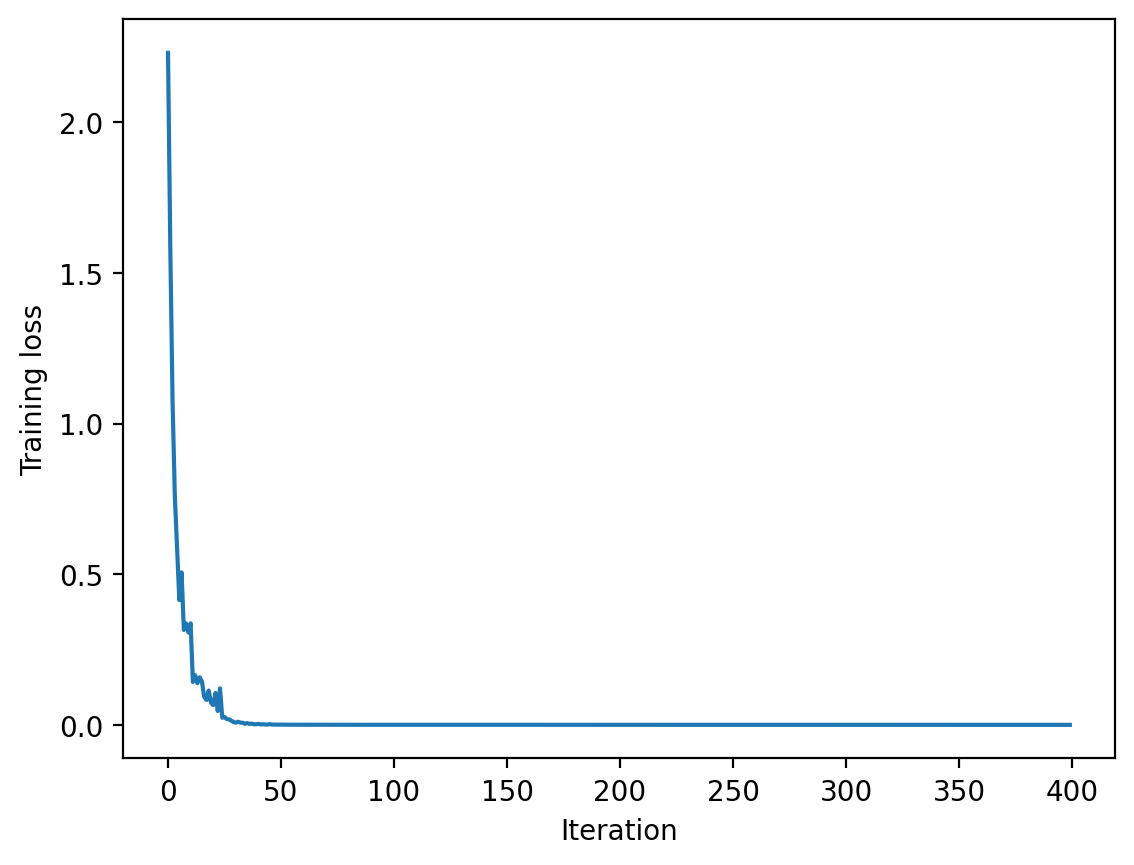

In [36]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

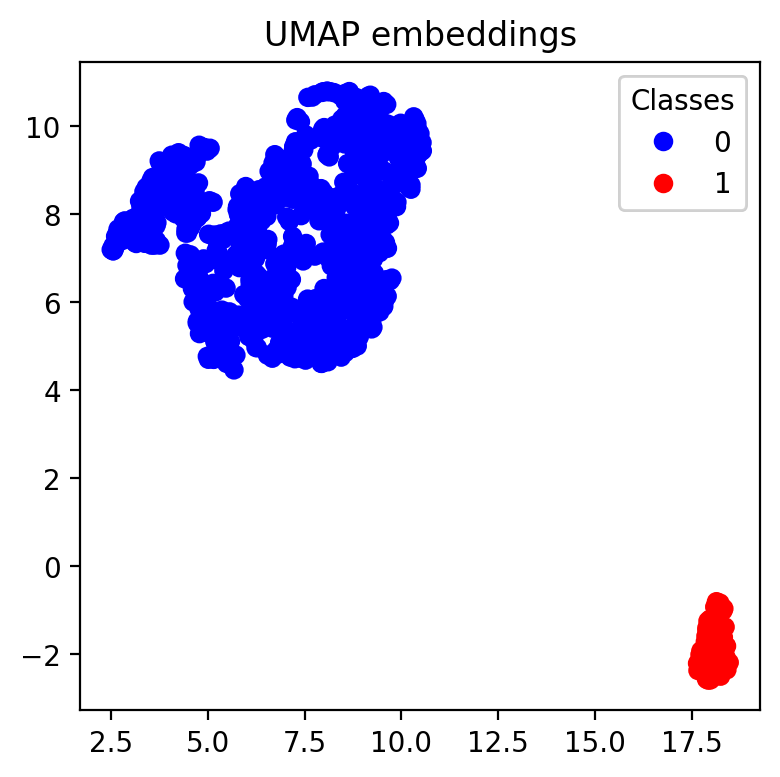

In [37]:
viz_embeddings(net_pretrained, X[train_idx], y[train_idx], device)

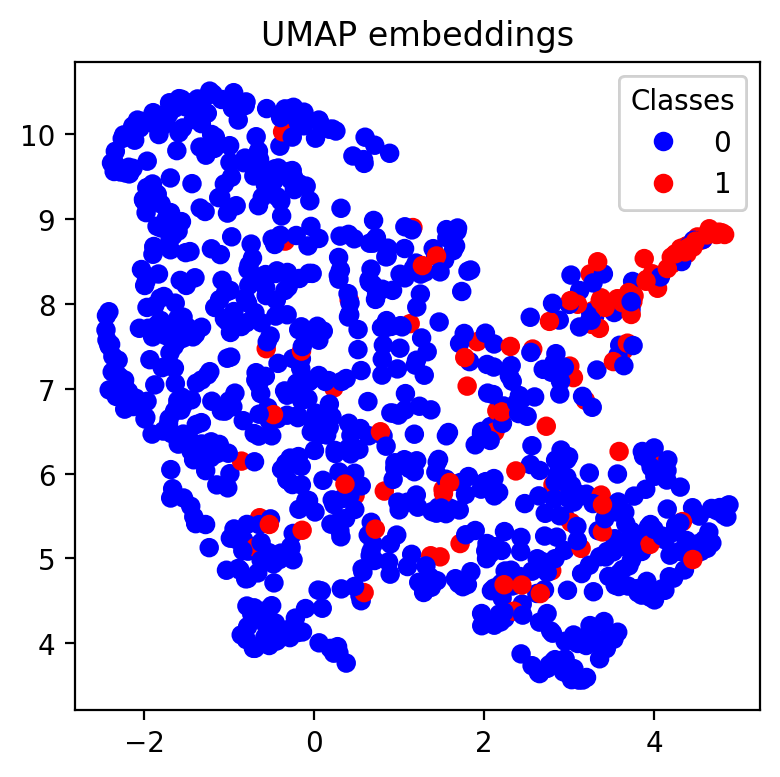

In [38]:
viz_embeddings(net_pretrained, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 100.00%
1000 1000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       893
           1       1.00      1.00      1.00       107

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



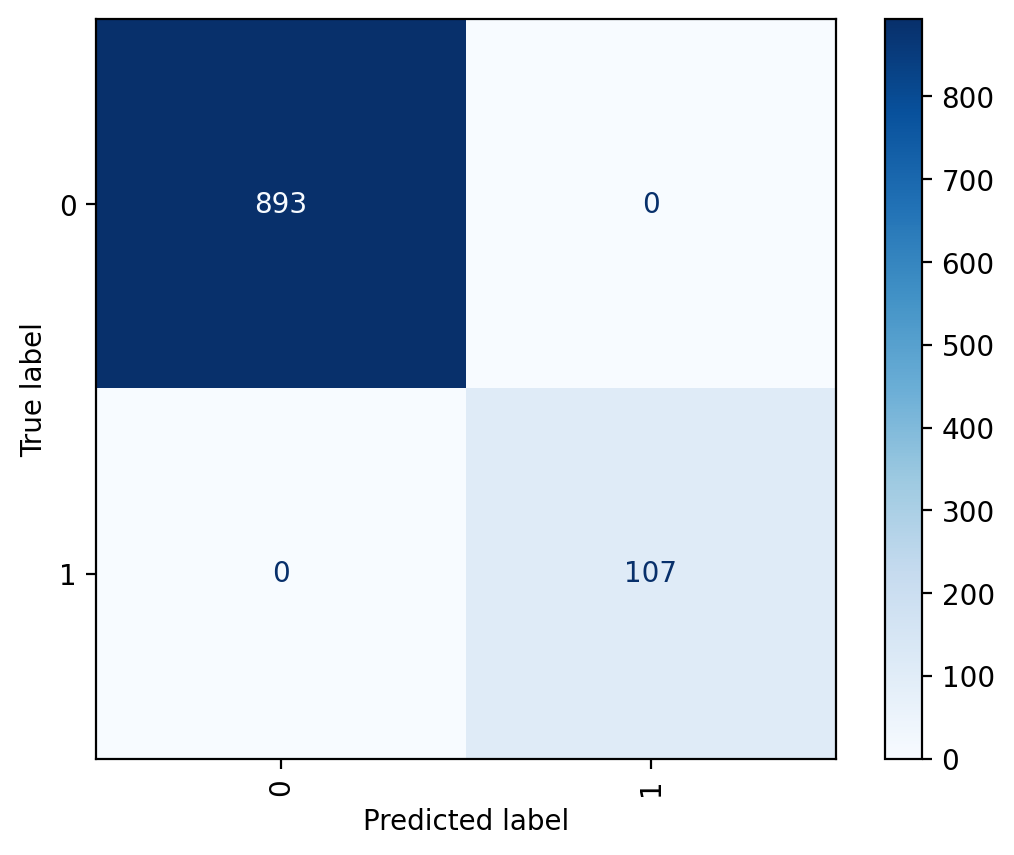

pool set accuracy: 91.04%
39000 39000
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     35115
           1       0.55      0.56      0.55      3885

    accuracy                           0.91     39000
   macro avg       0.75      0.75      0.75     39000
weighted avg       0.91      0.91      0.91     39000



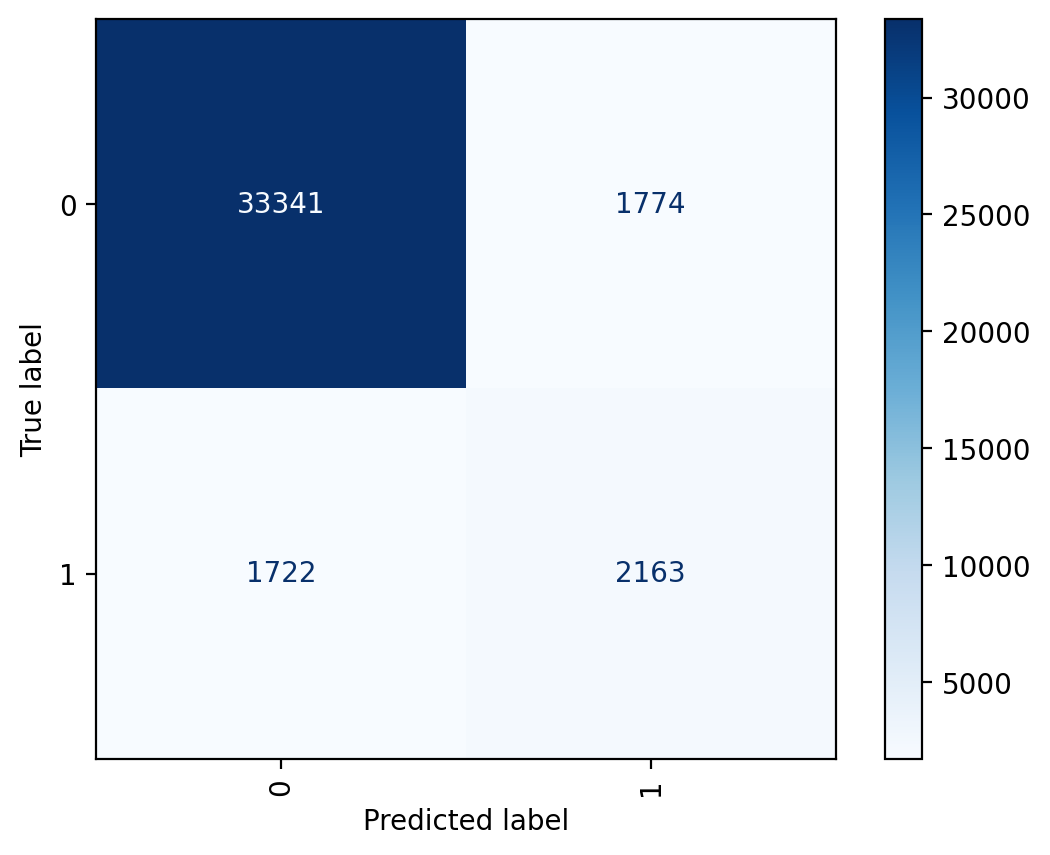

test set accuracy: 90.86%
20000 20000
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     17992
           1       0.55      0.54      0.54      2008

    accuracy                           0.91     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.91      0.91      0.91     20000



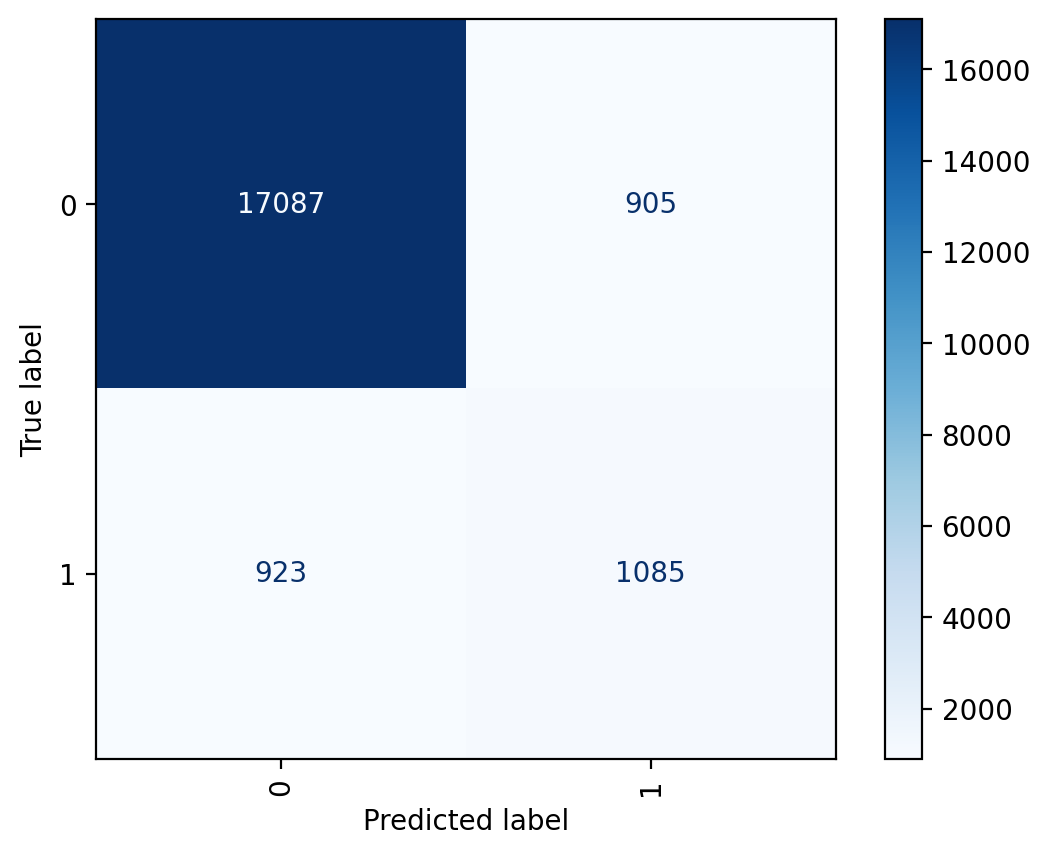

In [39]:
predict(net_pretrained, ["0", "1"], plot_confusion_matrix=True)